In [1]:
import cv2
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
import os
import random
from sklearn.manifold import TSNE
random.seed(42)

%matplotlib inline

In [47]:
IMAGE_SIZE = (70, 70)
def process_image(image_location):
    """
        Given the image location, process the image
    """
    # print(image_location)
    
    image = cv2.imread(image_location)
    
    if image.shape[0] != IMAGE_SIZE[0] or image.shape[1] != IMAGE_SIZE[1]:
        # print("Resizing the image: {0}".format(image_location))
        resized_image = cv2.resize(image, IMAGE_SIZE, interpolation = cv2.INTER_AREA)
    else:
        resized_image = image
    
    #gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
       
    return resized_image

In [48]:
type_locations = {"b": ["bb", "wb"], "n": ["bn", "wn"], "k": ["bk", "wk"], "p": ["bp", "wp"], "q": ["bq", "wq"], "r": ["br", "wr"]}
type_name_to_label = { "p":0, "b":1, "n":2, "r":3, "q": 4, "k":5 }

In [49]:
def get_features_labels(data_path):
    X, y = [], []
    features_with_labels = []
    
    for type_name in type_locations:
        for folder_name in type_locations[type_name]:
            piece_type_folder = os.path.join(data_path, folder_name)
            for f in (os.listdir(piece_type_folder)):
                if f.endswith(".jpg"): 
                    

                    img_file_loc = os.path.join(piece_type_folder, f)
                    # print(img_file_loc)
                    grayscale_image = process_image(img_file_loc)
                    actual_image = grayscale_image
                    
                    label = type_name_to_label[type_name]
                    features_with_labels.append({"feature": grayscale_image, "label": label})   
                    
    random.shuffle(features_with_labels)
    #print(X[0][0])
    #print(X[0][1])
    X = [x["feature"] for x in features_with_labels]
    y = [x["label"] for x in features_with_labels]
    
    X = np.array(X)
    X = X.astype('float32')
    X /= 255

    return X, np.array(y)

In [50]:
X_train, y_train = get_features_labels("/home/anurag/AR/data/23March/train")
X_test, y_test = get_features_labels("/home/anurag/AR/data/23March/test")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5838, 70, 70, 3)
(5838,)
(291, 70, 70, 3)
(291,)


## Let us try with Knights which has a bad prediction performance

In [51]:
def get_merged_images_with_labels(piece_type, num_train_images = 100, num_channels = 1):
    images_with_labels = []
    label_code = type_name_to_label[piece_type]
    
    curr_train_images = 0
    
    # put label 0 for train images
    for itr, l in enumerate(y_train):
        if curr_train_images >= num_train_images:
            break
            
        if l == label_code:
            curr_train_images += 1
            images_with_labels.append({"image": X_train[itr], "label": 0 })
    
    # use label 1 for test images
    for itr, l in enumerate(y_test):
        if l == label_code:
            images_with_labels.append({"image": X_test[itr], "label": 1 })
            
    random.shuffle(images_with_labels)

    X = np.array([x["image"] for x in images_with_labels])
    y = np.array([x["label"] for x in images_with_labels])
    
    return X.reshape((-1, IMAGE_SIZE[0] * IMAGE_SIZE[1] * num_channels)), y
        

In [52]:
knight_images, knight_labels = get_merged_images_with_labels("n", 900, 3)
print(knight_images.shape)
print(knight_labels.shape)

print(knight_images[0])
print(knight_labels[:5])

(960, 14700)
(960,)
[0.9137255  0.9490196  0.9607843  ... 0.83137256 0.8901961  0.9019608 ]
[0 0 0 0 0]


In [53]:
knight_labels[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [54]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
knight_images_reduced = tsne.fit_transform(knight_images)

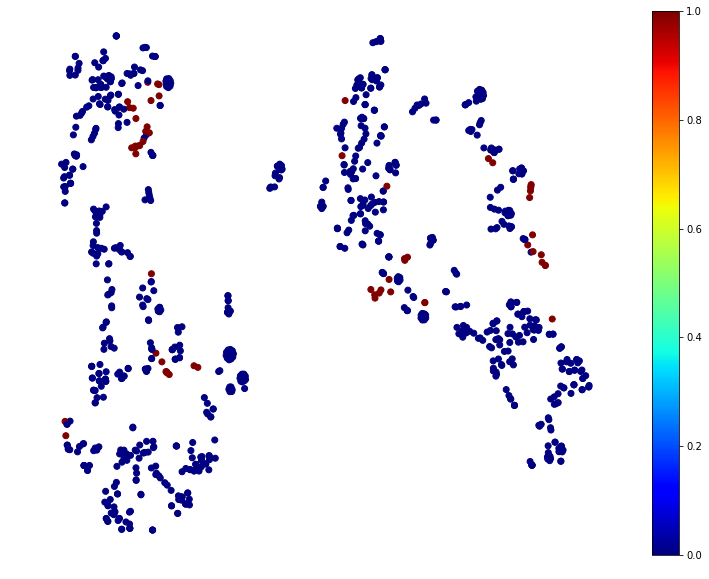

In [55]:
plt.figure(figsize=(13,10))
plt.scatter(knight_images_reduced[:, 0], knight_images_reduced[:, 1], c=knight_labels, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

In [58]:
import matplotlib
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_pieces(X, y, min_distance=0.05, num_channels = 1, images=None, figsize=(13, 10)):

    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = matplotlib.cm.get_cmap("jet")
    digits = np.unique(y)
    for l in {0, 1}:
        plt.scatter(X[y == l, 0], X[y == l, 1], c=cmap(l/2))
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            image = images[index].reshape((*IMAGE_SIZE, num_channels))
            imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
            ax.add_artist(imagebox)

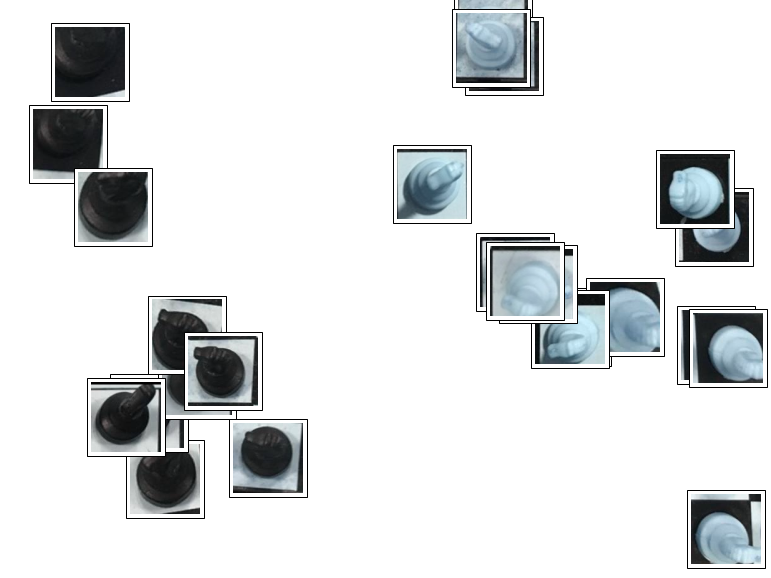

In [59]:
plot_pieces(knight_images_reduced[:25], knight_labels[:25], min_distance=0.05, num_channels = 3, images=knight_images[:25], figsize=(13, 10))